In [1]:
import numpy as np

x = np.arange(24).reshape( (2,2,2,3) )
x

array([[[[ 0,  1,  2],
         [ 3,  4,  5]],

        [[ 6,  7,  8],
         [ 9, 10, 11]]],


       [[[12, 13, 14],
         [15, 16, 17]],

        [[18, 19, 20],
         [21, 22, 23]]]])

In [2]:
np.swapaxes(x, 0, 3) 

array([[[[ 0, 12],
         [ 3, 15]],

        [[ 6, 18],
         [ 9, 21]]],


       [[[ 1, 13],
         [ 4, 16]],

        [[ 7, 19],
         [10, 22]]],


       [[[ 2, 14],
         [ 5, 17]],

        [[ 8, 20],
         [11, 23]]]])

In [25]:
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [27]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [7]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [8]:
print(y_train.shape)

(364,)


In [14]:
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b        # 선형 출력을 계산합니다.
        return z
    
    def activation(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m         # 가중치에 대한 그래디언트를 계산합니다.
        b_grad = np.sum(err) / m              # 절편에 대한 그래디언트를 계산합니다.
        return w_grad, b_grad    
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                  # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                            # 샘플 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))     # 가중치를 초기화합니다.
        self.b = 0                            # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())  # 가중치를 기록합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)               # 정방향 계산을 수행합니다.
            a = self.activation(z)            # 활성화 함수를 적용합니다.
            err = a - y                    # 오차를 계산합니다.
            # 오차를 역전파하여 그래디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)
            # 그래디언트에서 페널티 항의 미분 값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            # 가중치와 절편을 업데이트합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def predict(self, x):
        z = self.forpass(x)      # 정방향 계산을 수행합니다.
        return z > 0             # 스텝 함수를 적용합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.activation(z)             # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [28]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [17]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, 
                 x_val=x_val_scaled, y_val=y_val, epochs=1000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

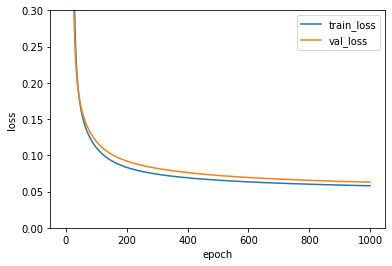

In [18]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [30]:
class DualLayer(SingleLayer):
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.activation(z1)            # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)               # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)          # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)
        m = len(x)                    # 샘플 개수를 저장합니다.
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            a = self.training(x, y, m)
            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.activation(z)    # 활성화 함수를 적용합니다.
        err = a - y            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

In [31]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, 
               x_val=x_val_scaled, y_val=y_val, epochs=2000)
dual_layer.score(x_val_scaled, y_val)

0.9120879120879121

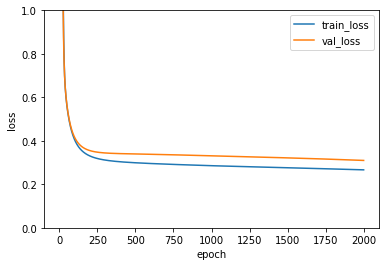

In [33]:
plt.ylim(0, 1.0)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [34]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, 1))           # (은닉층의 크기, 1)
        self.b2 = 0

In [35]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train,
                    x_val=x_val_scaled, y_val=y_val, epochs=500)

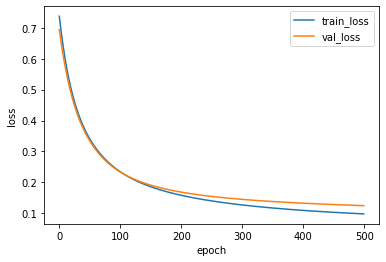

In [36]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [38]:
a = np.array([1,2,3,4,5,6,7,8,9])
b = [1,3,5,7]
a[b]

array([2, 4, 6, 8])

In [50]:
a = np.array([0,1,2,3,4,5,6,7,8,9])
a += 10
b = np.random.permutation(np.arange(len(a)))
a[b]

array([15, 19, 17, 11, 13, 14, 12, 10, 16, 18])

In [51]:
class MinibatchNetwork(RandomInitNetwork):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size     # 배치 크기
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿉니다.
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        np.random.seed(42)
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1) # 타깃을 열 벡터로 바꿉니다.
                m = len(x_batch)                 # 샘플 개수를 저장합니다.
                a = self.training(x_batch, y_batch, m)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.

In [57]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=64)
minibatch_net.fit(x_train_scaled, y_train, 
                  x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

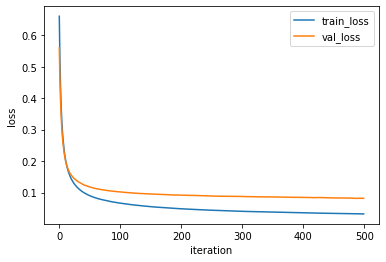

In [53]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [58]:
import numpy as np
temp = np.array([[2.20,1.39,0.85],
                 [0.00,-1.39,-2.20]])
exp_temp = np.exp(temp)
ret = exp_temp / np.sum(exp_temp, axis=1).reshape(-1, 1)
print( ret )

[[0.5868206  0.26105188 0.15212752]
 [0.73535983 0.18315997 0.08148019]]


In [ ]:
import numpy as np
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        z = np.clip(z, -100, None)            # 안전한 np.exp() 계산을 위해
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        np.random.seed(42)
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            loss = 0
            print('.', end='')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                a = self.training(x_batch, y_batch)
                # 안전한 로그 계산을 위해 클리핑합니다.
                a = np.clip(a, 1e-10, 1-1e-10)
                # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
                loss += np.sum(-y_batch*np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니배치 횟수
        if length % self.batch_size:
            bins += 1                    # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [23]:
import tensorflow as tf

In [24]:
tf.__version__

'2.3.0'

In [25]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


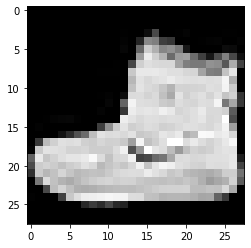

In [26]:
import matplotlib.pyplot as plt
#print(x_train_all[0])
plt.imshow(x_train_all[0], cmap='gray')
plt.show()